Second attempt: ODE to build PyTorch intuition

Imports

In [89]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)

Setup functions

In [90]:
def exact_solution(d,w0,t):
    assert d < w0
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

class FCN(nn.Module):
    def __init__(self,N_INPUT,N_OUTPUT,N_HIDDEN,N_LAYERS):
        super().__init__()
        activation = nn.Tanh

        self.fcs = nn.Sequential(*[         #unpacking operator
            nn.Linear(N_INPUT, N_HIDDEN),
            activation()])
            
        self.fch = nn.Sequential(*[
            nn.Sequential(*[
                nn.Linear(N_HIDDEN, N_HIDDEN),
                activation()]) for _ in range(N_LAYERS-1)])
        
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self,x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

Model definition

In [91]:
pinn = FCN(N_INPUT=1, N_OUTPUT=1, N_HIDDEN=32, N_LAYERS=3)

Boundary conditions

In [92]:
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

Physics loss

In [93]:
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

Training loop

Epoch 0: Loss = 0.9748555266117748


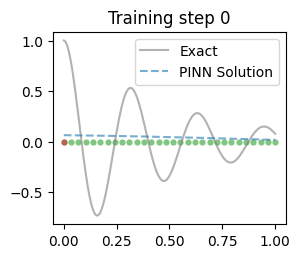

Epoch 1500: Loss = 0.021592958606392335


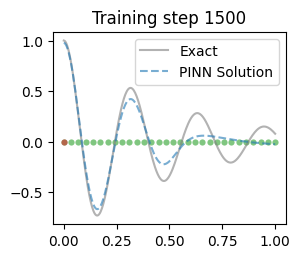

Epoch 3000: Loss = 0.013475127057037715


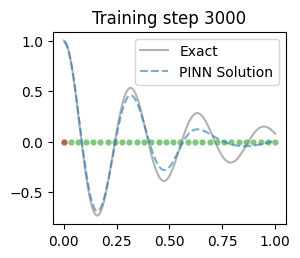

Epoch 4500: Loss = 0.011216898216721888


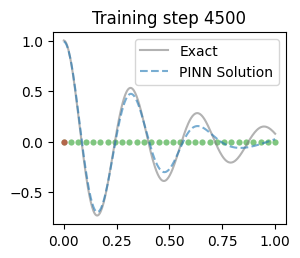

Epoch 6000: Loss = 0.009603781046331333


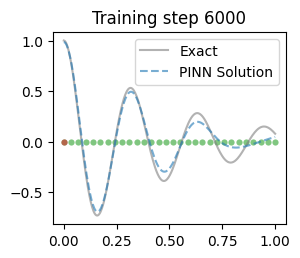

Epoch 7500: Loss = 0.036918242578889024


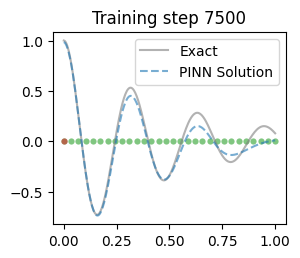

Epoch 9000: Loss = 0.001871964929263306


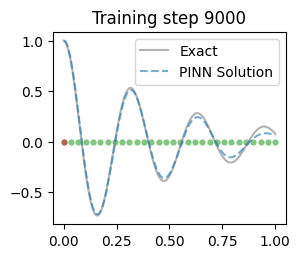

Epoch 10500: Loss = 0.0003228212392276066


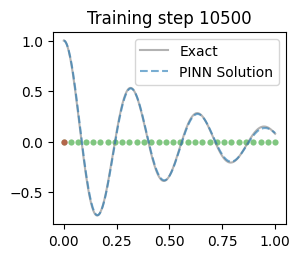

Epoch 12000: Loss = 0.00022602593405095865


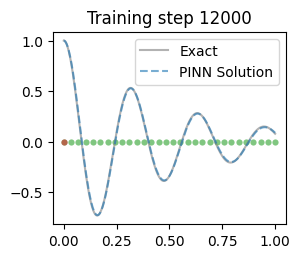

Epoch 13500: Loss = 0.00028574476205268365


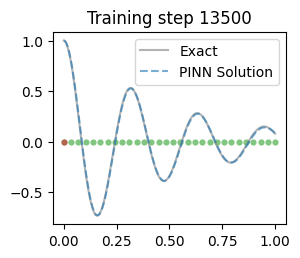

Epoch 15000: Loss = 0.00015991397855359473


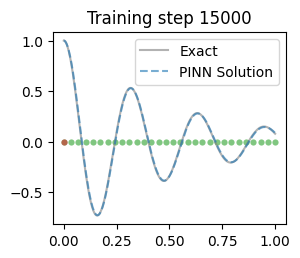

In [94]:
d, w0 = 2, 20
mu, k = 2*d, w0**2
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d,w0,t_test)
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)
for i in range(15001):
    optimizer.zero_grad()
    lambda1,lambda2 = 1e-1, 1e-4    #hyperparameters

    #boundary loss
    u = pinn(t_boundary)
    loss1 = torch.mean((torch.squeeze(u)-1)**2)

    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
    loss2 = torch.mean((torch.squeeze(dudt)-0)**2)

    #physics loss
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]

    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

    #backpropogation
    loss = loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward()
    optimizer.step()
    if i % 1500 == 0:
        print(f"Epoch {i}: Loss = {loss.item()}")
        u = pinn(t_test).detach()

        #plotting outputs
        plt.figure(figsize=(3,2.5))
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[0:,0],s=20,lw=0,color="tab:green",alpha=0.6)
        plt.scatter(t_boundary[:,0].detach(), 
                    torch.zeros_like(t_boundary[:,0]), s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0],u_exact[:,0],label='Exact',color="tab:grey",alpha=0.6)
        plt.plot(t_test[:,0],u[:,0],'--',label='PINN Solution',color="tab:blue",alpha=0.6)
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()